# PyTorch and Deep Neural Networks for Invasive Ductal Carcinoma (IDC)

We are going to classify images of ductal in situ carconima using transfer learning with pre-trained VGG16 model.  

- For this notebook we are going to use the Kaggle Breast Histopathology Dataset 277,524 50x50 pixel PNG image patches : https://www.kaggle.com/datasets/paultimothymooney/breast-histopathology-images

In [63]:
pip install tqdm

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [14]:
pip install netron

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 27.8 MB/s  0:00:00
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
Note: you may need to restart the kernel to use updated packages.


### Aim and background

The aim is to build an inductal in situ carcinoma classifier using transfer learning. We will fine-tune a pre-trained model on a custom dataset of histopathology images to enable it to classify In-Situ Carcinoma effectively.  

Hisotopathologic examination of biopsy samples is the definitive diagnostic test to diagnose in situ carcinoma.  Characteristics on pathology include: (1) Proliferation of malignant cells within breast ducts (2) Intact basement membrane (3) No stromal invasion.

### Final Output

The final output will be a trained deep learning model capable of classifying in situ carcinoma and visualize the accuracy and predictions on sample test images.

In [1]:
#Install required libraries

# Check if pip is available
import sys
print(sys.executable)

# Install packages using python3
!python3 -m pip install --upgrade pip
!python3 -m pip install --upgrade scipy scikit-learn
!python3 -m pip install tensorflow==2.16.2 matplotlib==3.9.2 numpy==1.26.4

/Library/Developer/CommandLineTools/usr/bin/python3
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
#Imports
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import random
import shutil

#Suppress Warnings
import warnings
from urllib3.exceptions import NotOpenSSLWarning
warnings.filterwarnings("ignore", category=NotOpenSSLWarning)
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppress all warnings and info messages

/Users/christopherleggett/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


### Download the input data 
Note: The dataset download may take up to 30 minutes depending on your internet connection. Please ensure a stable connection and wait until the download completes.

In [5]:
"""
SETUP INSTRUCTIONS:
1. Go to https://www.kaggle.com/account
2. Click "Create New API Token" to download kaggle.json
3. Open kaggle.json and copy your username and key
4. Replace "your_username" and "your_api_key" below with your actual credentials
5. Run this script - it will download and extract the breast cancer histopathology dataset
"""

import subprocess
import sys

# TODO: Replace with your actual Kaggle credentials generated from above steps
KAGGLE_USERNAME = "chrisrleggett"  # Replace with your Kaggle username
KAGGLE_KEY = "b88ce4d51fdf9582390c989523cb9b86"        # Replace with your Kaggle API key
DATASET_NAME = "paultimothymooney/breast-histopathology-images"  #Paul Mooney is the dataset author, do not change this line
extract_dir = "CancerClassification/histo-images-original-size" #Replace with your actual extract directory

def download_dataset():
    extract_dir = "CancerClassification/histo-images-original-size" #Replace with your actual extract directory
    
    print("Starting dataset download process...")
    
    # Check if dataset already exists and warn user
    if os.path.exists(extract_dir):
        print(f"WARNING: Dataset folder '{extract_dir}' already exists and will be deleted.")
        print("This will permanently remove all existing data in that folder.")
        confirm = input("Continue? (Y/n): ").strip().upper()
        
        if confirm != 'Y':
            print("Download cancelled.")
            return None
        
        print("Removing existing dataset...")
        import shutil
        shutil.rmtree(extract_dir)
        print("Existing dataset removed.")
    
    try:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "kaggle", "-q"], 
                             stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
        
        os.environ['KAGGLE_USERNAME'] = KAGGLE_USERNAME
        os.environ['KAGGLE_KEY'] = KAGGLE_KEY
        
        import kaggle
        print("Starting download...")
        
        kaggle.api.dataset_download_files(
            DATASET_NAME,
            path=".", unzip=False
        )
        print("Download complete")
        
        # Find and extract the downloaded zip
        zip_file = "breast-histopathology-images.zip"
        if os.path.exists(zip_file):
            print("Extracting dataset...")
            import zipfile
            with zipfile.ZipFile(zip_file, 'r') as zip_ref:
                zip_ref.extractall(extract_dir)
            os.remove(zip_file)
            print(f"Dataset extracted to: {extract_dir}")
            return extract_dir
        else:
            print("Zip file not found. Check current directory for downloaded files.")
            return None
        
    except Exception as e:
        print(f"Download failed: {e}")
        return None

if __name__ == "__main__":
    download_dataset()

Starting dataset download process...
Starting download...
Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/breast-histopathology-images
Download complete
Extracting dataset...
Dataset extracted to: CancerClassification/histo-images-original-size


### Visualize the first 3 patients 

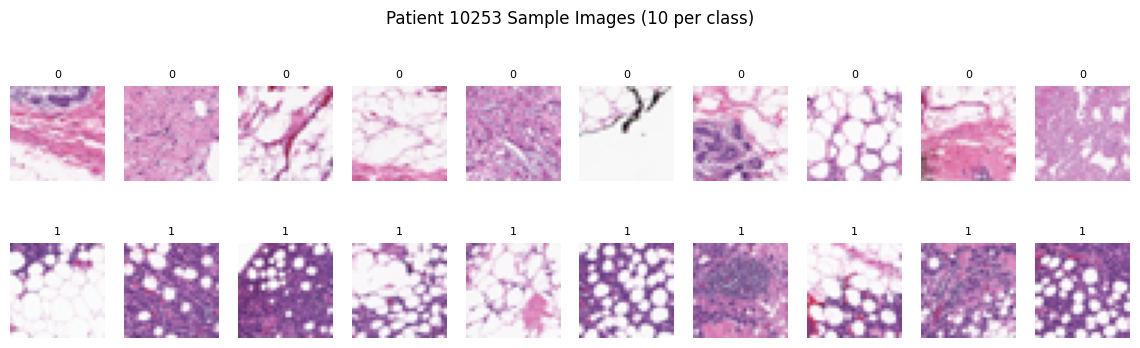

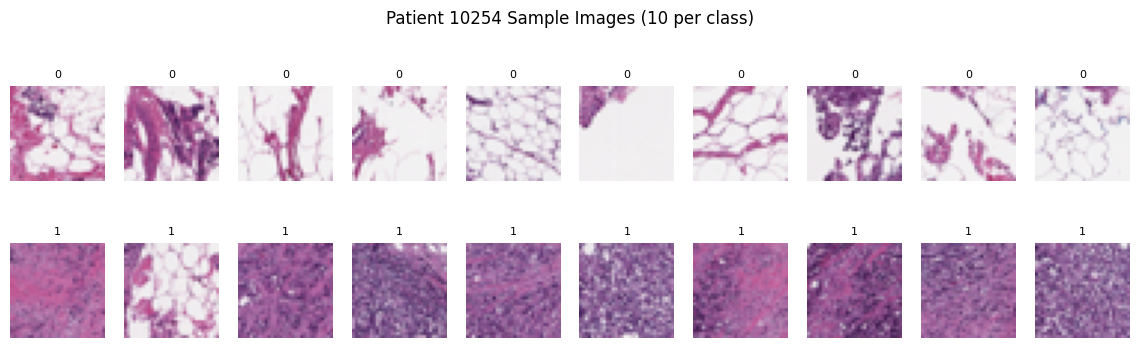

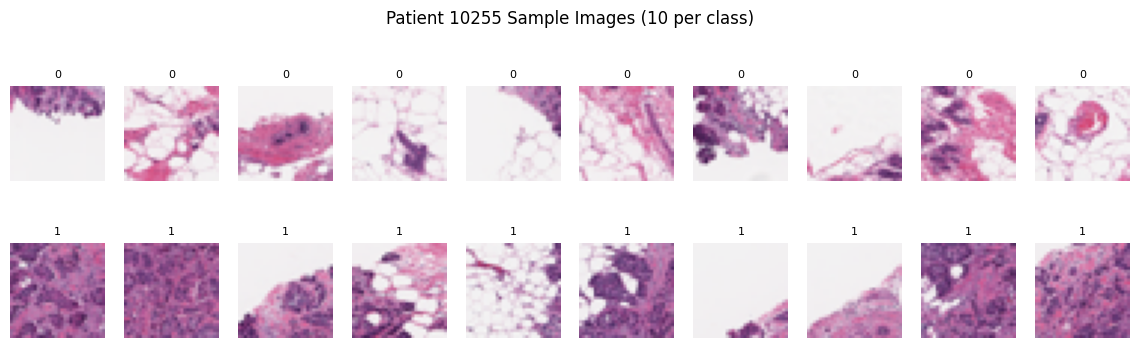

In [7]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# Get first 3 patient IDs
sample_patients = sorted([p for p in os.listdir(extract_dir) if os.path.isdir(os.path.join(extract_dir, p))])[:3]

# Loop through each patient
for patient_id in sample_patients:
    patient_path = os.path.join(extract_dir, patient_id)
    fig, axes = plt.subplots(2, 10, figsize=(14, 4))
    fig.suptitle(f'Patient {patient_id} Sample Images (10 per class)', fontsize=12)
    
    for row, cls in enumerate(['0', '1']):
        cls_path = os.path.join(patient_path, cls)
        if not os.path.exists(cls_path):
            continue
        images = os.listdir(cls_path)[:10]  # first 10 images
        for col, fname in enumerate(images):
            fpath = os.path.join(cls_path, fname)
            with Image.open(fpath) as img:
                img = img.resize((32, 32))
                axes[row, col].imshow(img)
                axes[row, col].axis('off')
                axes[row, col].set_title(cls, fontsize=8)
    
    # Center the grid of images in notebook
    plt.subplots_adjust(left=0.1, right=0.9, top=0.85, bottom=0.1, hspace=0.1)
    plt.show()

### Library Explanations:
- `ImageDataGenerator:` For loading images and applying data augmentation.
- `VGG16:` Pre-trained model used for transfer learning.
- `Sequential:` For building a sequential model.
- `Dense, Flatten, Dropout, BatchNormalization:` Layers to customize the model architecture.
- `ReduceLROnPlateau, EarlyStopping:` Callbacks for optimizing training.


In [94]:
import os
import shutil
import random

# Set Dataset Paths
train_dir = 'CancerClassification/train'
val_dir = 'CancerClassification/val'
test_dir = 'CancerClassification/test'
extract_dir = "CancerClassification/histo-images-original-size"

# Split ratios
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Allowed image extensions
image_extensions = ('.png', '.jpg', '.jpeg', '.tif', '.tiff', '.bmp')

# Create train/val/test directories for both classes
for base_dir in [train_dir, val_dir, test_dir]:
    for cls in ['0', '1']:
        os.makedirs(os.path.join(base_dir, cls), exist_ok=True)

# Get all patient IDs and split them (not images)
patients = [p for p in os.listdir(extract_dir) if os.path.isdir(os.path.join(extract_dir, p))]
random.shuffle(patients)

n_patients = len(patients)
n_train_patients = int(n_patients * train_ratio)
n_val_patients = int(n_patients * val_ratio)

# Split patients into sets
train_patients = patients[:n_train_patients]
val_patients = patients[n_train_patients:n_train_patients+n_val_patients]
test_patients = patients[n_train_patients+n_val_patients:]

print(f"Total patients: {n_patients}")
print(f"Train patients: {len(train_patients)}")
print(f"Validation patients: {len(val_patients)}")
print(f"Test patients: {len(test_patients)}")

# Copy all images from each patient to their assigned set
for patient_set, target_dir in [(train_patients, train_dir), 
                               (val_patients, val_dir), 
                               (test_patients, test_dir)]:
    
    for patient_id in patient_set:
        patient_path = os.path.join(extract_dir, patient_id)
        
        for cls in ['0', '1']:
            cls_path = os.path.join(patient_path, cls)
            if not os.path.exists(cls_path):
                continue
                
            # Get all valid images for this patient/class
            images = [
                img for img in os.listdir(cls_path) 
                if img.lower().endswith(image_extensions) and os.path.isfile(os.path.join(cls_path, img))
            ]
            
            # Copy ALL images from this patient to the target set
            for img in images:
                src = os.path.join(cls_path, img)
                dst = os.path.join(target_dir, cls, f"{patient_id}_{img}")
                shutil.copy(src, dst)

print("Patient-level splitting completed!")
print("Each patient's images are now in only one set (train/val/test)")

Total patients: 280
Train patients: 196
Validation patients: 42
Test patients: 42
Patient-level splitting completed!
Each patient's images are now in only one set (train/val/test)


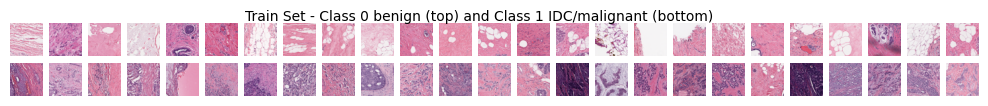

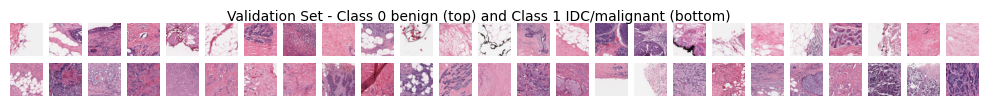

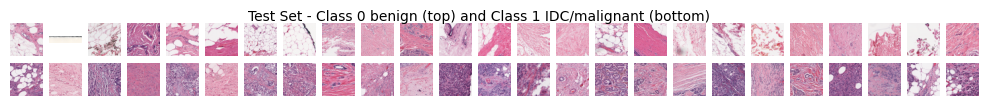

In [95]:
from matplotlib import pyplot as plt
from matplotlib import image as mpimg

# Build dictionary dynamically
dataset_dirs = {
    "Train": train_dir,
    "Validation": val_dir,
    "Test": test_dir
}

# Number of images per class to preview
n_images = 25
classes = ['0', '1']

for set_name, base_dir in dataset_dirs.items():

    
    # Slightly larger images
    fig, axes = plt.subplots(2, n_images, figsize=(n_images*0.5, 2*0.5))  
    plt.suptitle(f"{set_name} Set - Class 0 benign (top) and Class 1 IDC/malignant (bottom)", fontsize=10)
    
    for i, cls in enumerate(classes):
        cls_path = os.path.join(base_dir, cls)
        if not os.path.exists(cls_path):
            continue
        
        images = [img for img in os.listdir(cls_path) if img.lower().endswith(('.png','.jpg','.jpeg','.tif','.tiff','.bmp'))]
        sampled_images = random.sample(images, min(n_images, len(images)))
        
        for j, img_name in enumerate(sampled_images):
            img_path = os.path.join(cls_path, img_name)
            img = mpimg.imread(img_path)
            ax = axes[i, j]
            ax.imshow(img)
            ax.axis('off')
    
    # Adjust spacing to accommodate suptitle
    plt.subplots_adjust(top=0.85)
    plt.show()

In [96]:
"""
1. IMAGE DATA GENERATORS
"""
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# train_datagen: rescale + mild augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

"""
2. LOAD IMAGES FROM DIRECTORIES
"""
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(56, 56),       # increased to match VGG16
    batch_size=32,
    class_mode='binary',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(56, 56),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(56, 56),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)


Found 191256 images belonging to 2 classes.
Found 40044 images belonging to 2 classes.
Found 46224 images belonging to 2 classes.


In [97]:
"""
3. MODEL DEFINITION
"""
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout
from tensorflow.keras import regularizers

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(56, 56, 3))
for layer in base_model.layers:
    layer.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
    BatchNormalization(),
    Dropout(0.7),
    Dense(1, activation='sigmoid')
])

### Compile the model with loss and optimizer

In [98]:
'''
Layer Freezing and Unfreezing 
'''

# Freeze everything 
for layer in model.layers[0].layers:
    layer.trainable = False

    
"""
5. CALLBACKS + COMPILE
"""
from tensorflow.keras.mixed_precision import set_global_policy
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

set_global_policy('float32')

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, min_lr=1e-6, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

from tensorflow.keras.optimizers import Adam
model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=1e-4, clipnorm=1.0),
    metrics=['accuracy']
)

"""
6. COMPUTE CLASS WEIGHTS
"""
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

print("Computing class weights...")
try:
    classes = np.unique(train_generator.classes)
    class_weights_array = compute_class_weight(
        class_weight='balanced',
        classes=classes,
        y=train_generator.classes
    )
    class_weights = dict(zip(classes, class_weights_array))
except:
    class_weights = {0: 0.7, 1: 1.76}

print("Class weights:", class_weights)

"""
7. TRAINING PARAMETERS: NOTE THESE SHOULD BE INCREASED DURING ACTUAL TRAINING
"""
steps_per_epoch = int(np.ceil(train_generator.samples / train_generator.batch_size) / 4)  # Use % of data remove the denominator to use more of training samples
validation_steps = int(np.ceil(val_generator.samples / val_generator.batch_size) / 4)   # Use % of data
print(f"Training: {steps_per_epoch} steps/epoch, {validation_steps} validation steps")

"""
8. TRAIN THE MODEL
"""
history = model.fit(
    train_generator,
    epochs=3,
    validation_data=val_generator,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[lr_scheduler, early_stopping],
    class_weight=class_weights
)

Computing class weights...
Class weights: {0: 0.7060751941876606, 1: 1.713149408814045}
Training: 1494 steps/epoch, 313 validation steps
Epoch 1/3


/Users/christopherleggett/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1494/1494 ━━━━━━━━━━━━━━━━━━━━ 195s 130ms/step - accuracy: 0.6248 - loss: 0.7543 - val_accuracy: 0.7858 - val_loss: 0.5217 - learning_rate: 1.0000e-04
Epoch 2/3
1494/1494 ━━━━━━━━━━━━━━━━━━━━ 213s 143ms/step - accuracy: 0.7199 - loss: 0.5994 - val_accuracy: 0.7907 - val_loss: 0.5133 - learning_rate: 1.0000e-04
Epoch 3/3
1494/1494 ━━━━━━━━━━━━━━━━━━━━ 210s 141ms/step - accuracy: 0.7503 - loss: 0.5477 - val_accuracy: 0.7983 - val_loss: 0.5074 - learning_rate: 1.0000e-04


### Visualize training performance with accuracy and loss curves ¶

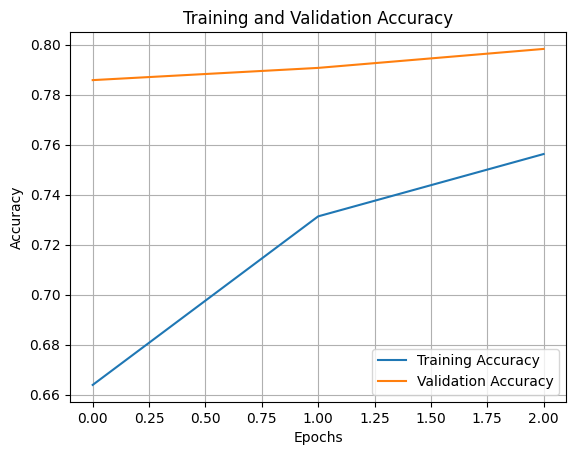

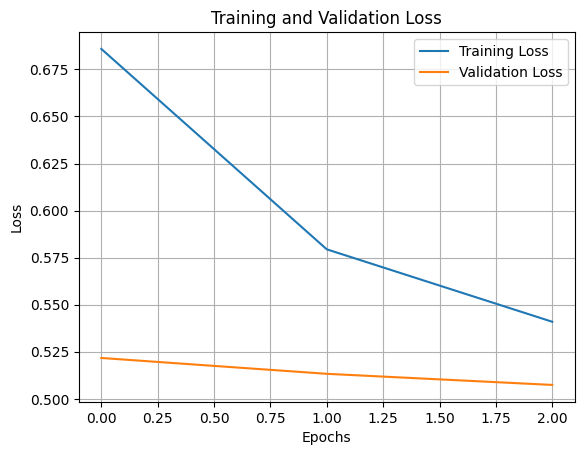

In [99]:
# Plot accuracy curves
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.grid(True)
plt.show()

# Plot loss curves
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.grid(True)
plt.show()

### Evaluate the model on the test set and display accuracy

In [100]:
from tqdm import tqdm
import numpy as np

# Quick test with progress bar
test_steps = 50
correct = 0
total = 0

for i in tqdm(range(test_steps)):
    batch_x, batch_y = next(test_generator)
    predictions = model.predict(batch_x, verbose=0)
    pred_classes = (predictions > 0.5).astype(int).flatten()
    
    correct += np.sum(pred_classes == batch_y)
    total += len(batch_y)

accuracy = correct / total
print(f"Test Accuracy: {accuracy * 100:.2f}% ({correct}/{total})")

100%|███████████████████████████████████████████████████████████████████████| 50/50 [00:06<00:00,  7.25it/s]

Test Accuracy: 75.19% (1203/1600)


### Test model predictions on sample images and visualize results

Sample Accuracy: 0.75 (18/24 correct)


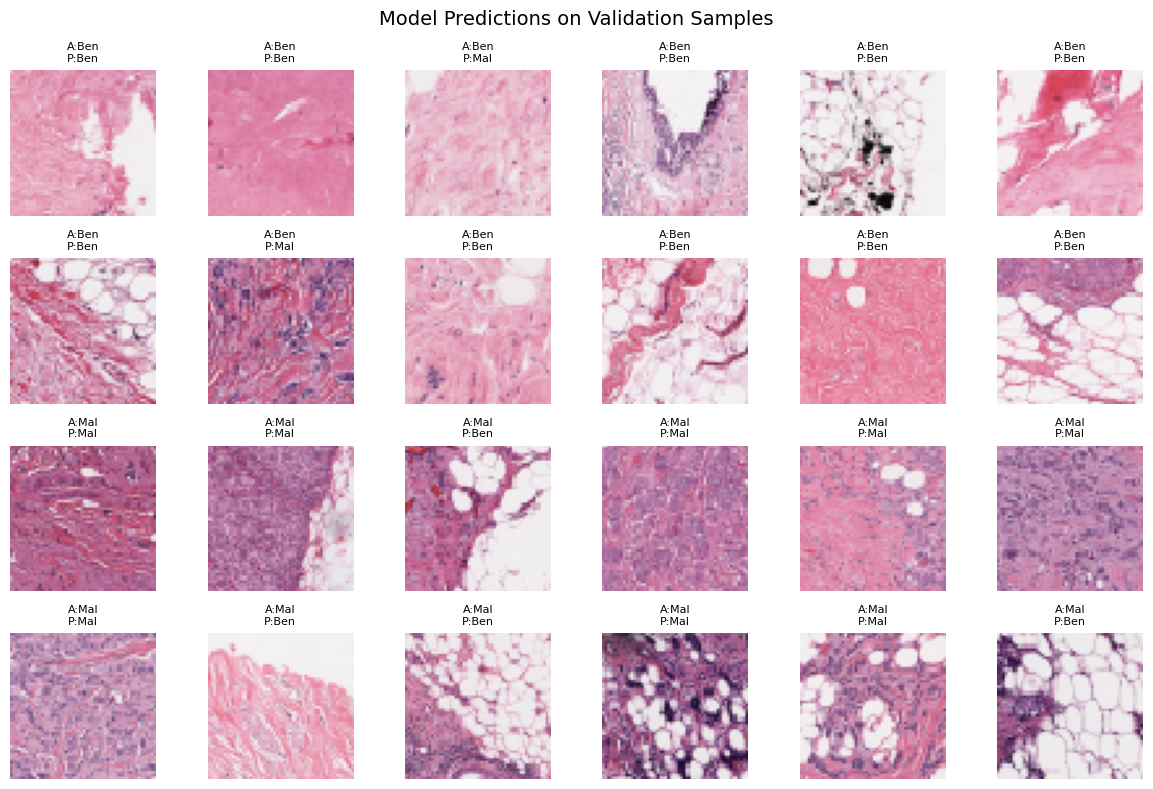

In [103]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import matplotlib.pyplot as plt
import random

# Get sample images from validation set
sample_images = []
for class_folder in ['0', '1']:
    class_path = os.path.join(val_dir, class_folder)
    images = [img for img in os.listdir(class_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
    sample_images.extend([os.path.join(class_path, img) for img in random.sample(images, 12)])

# Calculate accuracy
correct = 0
for img_path in sample_images:
    class_folder = os.path.basename(os.path.dirname(img_path))
    actual_class = int(class_folder)
    
    img_array = np.expand_dims(img_to_array(load_img(img_path, target_size=(56, 56))) / 255.0, axis=0)
    prediction = model.predict(img_array, verbose=0)[0][0]
    predicted_class = 1 if prediction > 0.5 else 0
    
    if actual_class == predicted_class:
        correct += 1

accuracy = correct / len(sample_images)
print(f"Sample Accuracy: {accuracy:.2f} ({correct}/{len(sample_images)} correct)")

# Visualize predictions in grid
fig, axes = plt.subplots(4, 6, figsize=(12, 8))
fig.suptitle('Model Predictions on Validation Samples', fontsize=14)

for i, img_path in enumerate(sample_images):
    class_folder = os.path.basename(os.path.dirname(img_path))
    actual = 'Benign' if class_folder == '0' else 'Malignant'
    
    img_array = np.expand_dims(img_to_array(load_img(img_path, target_size=(56, 56))) / 255.0, axis=0)
    prediction = model.predict(img_array, verbose=0)[0][0]
    predicted = 'Malignant' if prediction > 0.5 else 'Benign'
    
    ax = axes[i//6, i%6]
    ax.imshow(load_img(img_path, target_size=(56, 56)))
    ax.set_title(f"A:{actual[:3]}\nP:{predicted[:3]}", fontsize=8)
    ax.axis('off')

plt.tight_layout()
plt.show()